In [2]:
from matplotlib import pyplot as plt
import numpy as np
import math

import sys
sys.path.append('../scripts/code')

from pce import PCE
import distribution as distr
from test_functions_a import *

%matplotlib inline

In [3]:
exp_name = 'experiments/test_risk_5_'
save_all = True 

In [4]:
seed = 0
np.random.seed(seed)

In [5]:
n_test = 10**6

In [6]:
sample_sizes = None

In [7]:
num_runs = 100 #30 #!!!

## Experiment: Sobol g-function

In [8]:
#  =======================================================================
# Define Sobol g-function



sobol_a =  [0, 0.5]# [0.0, 4.0] #[0.0, 1.0, 3.5]        #[1.7, 1.5, 0.5, 0.0, 1.0, 2.5, 0.0, 0.5, 0.7, 1] #  [0.0, 0.1]#  #[0.0, 0.5, 0.7, 1] #  # #  # [0, 0.5, 0.7, 1] #  
#a = [1.7, 1.5, 0.5, 0.0, 1.0, 2.5, 0.0, 0.5, 0.7, 1]

def function(X):
    return sobol_g_func(sobol_a, X)[:, np.newaxis]

dim = len(sobol_a)
lb = -1.0
ub = 1.0

true_Sobol_indices = get_indices_sobol_g_func(sobol_a, full=True)


#  ==================================================================
# Approximation setting

max_degree = 4 #10 #!!!



#  ==================================================================
# Experiment setting

start_power = 1.4
end_power = 7 # training sample size = 10^end_power
num = 110 #!!!


function_name = 'Sobol'
function_parameters = {'sobol_a':sobol_a}


In [9]:
exp_name += function_name

In [10]:
import os
import dill
print(dill.__version__)

db_name = exp_name+'.db'
if os.path.isfile(db_name):
    print('\n=============== Loading %s ======================\n'%db_name)
    dill.load_session(db_name) #!!!
    raise SystemExit("Workspace is loaded.")
else:
    print('Workspace %s not found'%db_name)

0.3.1.1

=============== Loading experiments/test_risk_5_Sobol.db ======================



SystemExit: Workspace is loaded.

/home/ivan/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Code

In [13]:
ranges = lb * np.ones((dim, 2))
ranges[:, 0] = ub


test_X = np.random.rand(n_test, dim)
test_X = (ranges[:, 1] - ranges[:, 0]) * test_X + ranges[:, 0]


test_Y = function(test_X)

# true_Sobol_indices_selected = get_indices_sobol_g_func(sobol_a)
# true_SI = true_Sobol_indices_selected['main']
# true_TI = true_Sobol_indices_selected['total']

# print('main:', true_SI)
# print('main:', true_SI_full, '\n')

true_SI_full = true_Sobol_indices['main']
true_TI_full = true_Sobol_indices['total']



groups = tuple(true_SI_full.keys())

S_full = [true_SI_full[g] for g in groups]
T_full = [true_TI_full[g] for g in groups]

# S_full, T_full

In [14]:
basis_truncation = {'max_degree':max_degree}

marginals = distr.Marginals([distr.Uniform(lb, ub)]*dim) #!!!

model = PCE(marginals, basis_truncation)

print(model)
print('\nbasis_functions_number:', model._basis_functions_number)


PCE_parameters = {'basis_truncation':basis_truncation, 'model':str(model)}

PCE(marginals=Marginals([Uniform(a=-1.0, b=1.0, Legendre), Uniform(a=-1.0, b=1.0, Legendre)]), basis_truncation={'max_degree': 4})

basis_functions_number: 25


In [15]:
N = model._basis_functions_number

In [16]:
indices_full_number = len(groups)
indices_full_number

3

In [154]:
L = np.max(np.abs(test_Y))


#sigma = L/0.5 #!!!!

sigma_list = [0, L/10, 2*L] # , 10*L
var_f = np.var(test_Y)

var_f, L, sigma_list

(0.5306361108375467,
 3.3263272718973815,
 [0, 0.33263272718973813, 6.652654543794763])

In [12]:
# np.std(sigma*np.random.randn(1, 5000)), np.mean(sigma*np.random.randn(1, 5000))

In [13]:
%%time

if sample_sizes is None:
    sample_sizes = np.logspace(start_power, end_power, num=num, endpoint=True, base=10.0, dtype=np.int)
print('sample_sizes', sample_sizes)
print('sigma_list', sigma_list)

max_n = max(sample_sizes)

#rrmse = np.nan * np.ones((num_runs, len(sample_sizes)))
appr_SI =  np.nan * np.ones((num_runs, len(sample_sizes), indices_full_number))
appr_TI =  np.nan * np.ones((num_runs, len(sample_sizes),  indices_full_number))

#rrmse_proj = np.nan * np.ones((num_runs, len(sample_sizes)))
appr_SI_proj =  np.nan * np.ones((num_runs, len(sample_sizes), indices_full_number))
appr_TI_proj =  np.nan * np.ones((num_runs, len(sample_sizes),  indices_full_number))


err_S_list = []
err_S_proj_list = []


for sigma in sigma_list:
    
    print('='*20,'sigma:', sigma, '='*20)
    
    for j in range(num_runs):

        print('\nRun', j, '\n')

        all_X = (ranges[:, 1] - ranges[:, 0]) * np.random.rand(max_n, dim) + ranges[:, 0]
        all_Y = function(all_X) + sigma * np.random.randn(max_n, 1)


        for i, n in enumerate(sample_sizes):

            print(i, n, 'training samples')

            X = all_X[:n].copy()
            Y = all_Y[:n].copy()


            if model._basis_functions_number <= n:
                model.fit(X, Y, method='ls') # 'projection' 

                #rrmse[j, i] = model.validate(test_X, test_Y)['rrmse']
                appr_SI[j, i] = [model.get_sobol_indices(ind_type='main', full=True)[g] for g in groups]
                appr_TI[j, i] = [model.get_sobol_indices(ind_type='total', full=True)[g] for g in groups]



            model.fit(X, Y, method='projection' ) 

            #rrmse_proj[j, i] = model.validate(test_X, test_Y)['rrmse']
            appr_SI_proj[j, i] = [model.get_sobol_indices(ind_type='main', full=True)[g] for g in groups]
            appr_TI_proj[j, i] = [model.get_sobol_indices(ind_type='total', full=True)[g] for g in groups]


    indices_errors = np.dstack((np.abs(appr_SI - S_full)**2, np.abs(appr_TI - T_full)**2))
    mean_indices_errors = np.mean(indices_errors, axis=0)
    max_indices_errors = np.max(mean_indices_errors, axis=1)
    err_S = max_indices_errors
    err_S_list += [err_S]



    indices_errors_proj = np.dstack((np.abs(appr_SI_proj - S_full)**2, np.abs(appr_TI_proj - T_full)**2))
    mean_indices_errors_proj = np.mean(indices_errors_proj, axis=0)
    max_indices_errors_proj = np.max(mean_indices_errors_proj, axis=1)
    err_S_proj = max_indices_errors_proj
    err_S_proj_list += [err_S_proj]

        
        
        

sample_sizes [      25       28       31       35       40       45       51       57
       64       72       81       92      103      116      131      148
      166      187      211      237      267      301      339      381
      429      483      544      612      689      776      873      983
     1106     1245     1402     1578     1776     1999     2250     2533
     2851     3209     3612     4066     4576     5151     5798     6526
     7346     8268     9306    10475    11791    13271    14938    16814
    18926    21302    23978    26989    30378    34193    38487    43320
    48761    54884    61776    69534    78266    88095    99158   111610
   125626   141403   159160   179147   201644   226967   255469   287551
   323662   364307   410056   461551   519512   584753   658185   740840
   833874   938592  1056460  1189130  1338460  1506543  1695734  1908683
  2148375  2418166  2721838  3063645  3448376  3881421  4368848  4917485
  5535020  6230105  7012478  7893101  

In [38]:
model.info()

NameError: name 'model' is not defined

In [15]:
file_save = 'risk_'+ function_name + '_3.npz' #!!!
np.savez(file_save, sigma_list, sample_sizes, err_S_proj_list, err_S_list, L, N, var_f, num_runs,
         function_name, function_parameters, PCE_parameters) #!!!

In [148]:
N

25

In [150]:
def get_model_limit_mse(model, test_X, test_Y):
    
    test_size = int(len(test_X)*0.3)
    print('train size:', len(test_X)-test_size, ' + test size:', test_size)
    
    lambdas = np.array([0, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1])
    
    err = []
    for ls_lambda in lambdas:
        model.fit(test_X[test_size:], test_Y[test_size:], method='ls', ls_lambda=ls_lambda)
        err += [ model.validate(test_X[:test_size], test_Y[:test_size])['mse'] ]
        
    err = np.array(err)
    print('Errors:', err)
    print('lambda opt:', lambdas[err == np.min(err)])
    
    return np.min(err)

mse = get_model_limit_mse(model, test_X, test_Y)

train size: 700000  + test size: 300000
Errors: [0.00904814 0.00904814 0.00904813 0.00904812 0.00904938 0.00919423
 0.02156861]
lambda opt: [0.0001]


In [151]:
mse 

0.00904812450902612

In [156]:
mse  / var_f

0.017051467708717974

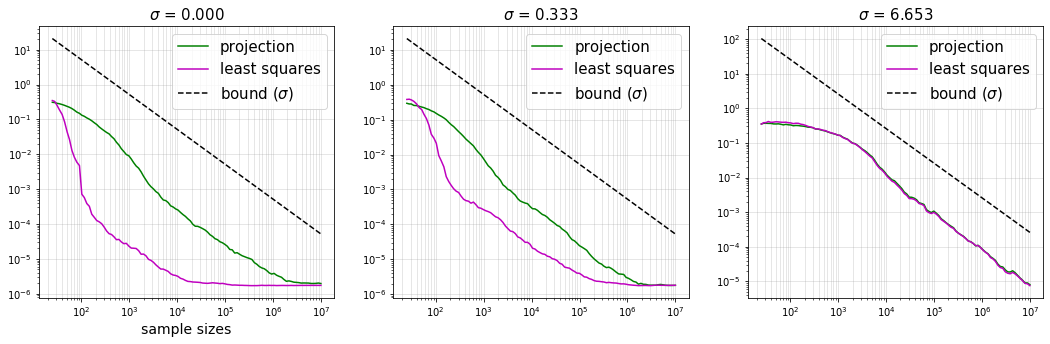

In [55]:
n_sig = len(sigma_list)

marker=None #'o'
linestyle=None#'--'

fontsize = 15 # legend

sample_sizes = np.array(sample_sizes) # , dtype=float
ind = sample_sizes > 0 # sample_sizes > 500


plt.figure(figsize=(18, 5))

for l in range(n_sig):
    

    plt.subplot(1, n_sig, l+1)
    plt.title('$\sigma$ = {:.3f}'.format(sigma_list[l]), fontsize=fontsize)

    plt.loglog(sample_sizes[ind], err_S_proj_list[l][ind], label='projection',linestyle=linestyle, marker=marker, color='g')

    plt.loglog(sample_sizes[ind], err_S_list[l][ind], label='least squares',linestyle=linestyle, marker=marker, color='m')
    
    k = (L**2+sigma_list[l]**2) * N / var_f
    
    plt.loglog(sample_sizes[ind], k/sample_sizes[ind], label='bound ($\sigma$)',linestyle='--', color='k')
    
    #plt.loglog(sample_sizes[ind], [mse / var_f] * sum(ind), label='bound ($e_N$)',linestyle='--', color='k')
    
    if l == 0:
        plt.xlabel('sample sizes', fontsize=14)
    
    #     if l == 0:
    #         plt.ylabel('Empirical risk of SI', fontsize=14)
    plt.legend(loc='best', fontsize=fontsize)
    
    plt.grid(b=True, which='both', color='#999999', axis='x',linestyle='-', alpha=0.3)
    plt.grid(b=True, which='major', color='#999999', axis='y',linestyle='-', alpha=0.3)

    
    
if save_all:
    fname = exp_name+'_noise.png'
    plt.savefig(fname, dpi=300, bbox_inches='tight', pad_inches=0.05)


In [17]:
# (L**2+sigma_list[l]**2) * N / var_f

In [18]:
# np.log10(N)

In [20]:
# 

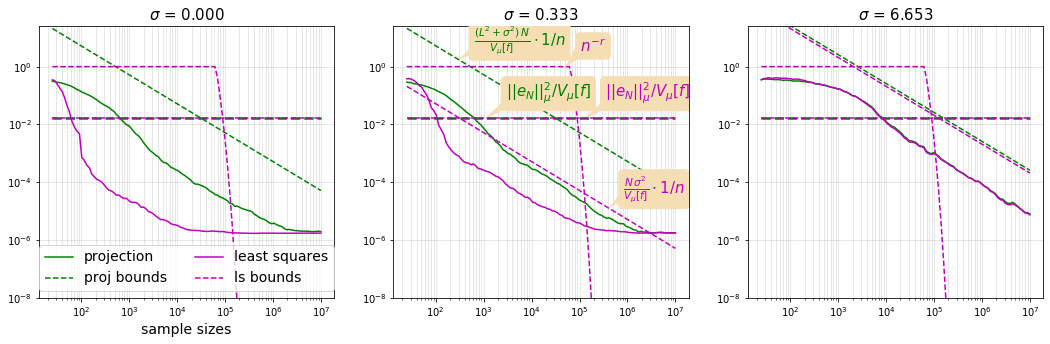

In [147]:
K_N = N**2 #!!!

ka = K_N * np.log(sample_sizes) / sample_sizes

r = -1 + (3 * np.log(3/2) - 1) / (2 * ka)

r[r < 0] = 0

r[r > 3] = np.nan # 1.35

# =================================================
from matplotlib.patches import Ellipse

def add_annotation(text,textcolor, xy, xytext):
    col = 'wheat'#,'papayawhip'#'blanchedalmond' #'oldlace'#'beige'#'ivory'#
    el = Ellipse((0, 0), 10, 20, facecolor=col, alpha=0.5)
    ann = ax.annotate(text,
                  xy=xy, xycoords='data',
                  xytext=xytext, textcoords='offset points',
                  size=fontsize,
                  color=textcolor,
                  bbox=dict(boxstyle="round",
                            color=col, #'w', # ,
                            ec=col), # 'wheat'
                  arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                  color=col, #'w', # 
                                  ec=col, # 'k',
                                  patchA=None,
                                  patchB=el,
                                  relpos=(0.2, 0.8),
                                  connectionstyle="arc3,rad=-0.1"),
                   clip_on=True)

# ===============================
n_sig = len(sigma_list)

marker=None #'o'
linestyle=None#'--'

fontsize = 15 # legend

sample_sizes = np.array(sample_sizes) # , dtype=float
ind = sample_sizes > 0 # sample_sizes > 500


plt.figure(figsize=(18, 5))

for l in range(n_sig):
    

    ax = plt.subplot(1, n_sig, l+1)
    
    plt.title('$\sigma$ = {:.3f}'.format(sigma_list[l]), fontsize=fontsize)

    plt.loglog(sample_sizes[ind], err_S_proj_list[l][ind], label='projection',linestyle=linestyle, 
               marker=marker, color='g')
    
    k = (L**2+sigma_list[l]**2) * N / var_f
    plt.loglog(sample_sizes[ind], k/sample_sizes[ind],linestyle='--', color='g',
              label='proj bounds') # label='bound ($L, \sigma$)'

    plt.loglog(sample_sizes[ind], err_S_list[l][ind], label='least squares',linestyle=linestyle, 
               marker=marker, color='m')
    

    k2 = sigma_list[l]**2 * N / var_f
    plt.loglog(sample_sizes[ind], k2/sample_sizes[ind],linestyle='--', color='m') # , label='bound ($\sigma$)'
    
    
    plt.loglog(sample_sizes[ind], [mse / var_f] * sum(ind),linestyle='--', color='g', 
               linewidth=2.5) # label = 'bound ($e_N$)'
    plt.loglog(sample_sizes[ind], [mse / var_f] * sum(ind), label='ls bounds',linestyle='--', color='m') # 'bound ($e_N$)'

    plt.loglog(sample_sizes[ind], sample_sizes[ind]**-r[ind], linestyle='--', color='m') # label='$n^{-r}$',
    
    
        
    plt.grid(b=True, which='both', color='#999999', axis='x',linestyle='-', alpha=0.3)
    plt.grid(b=True, which='major', color='#999999', axis='y',linestyle='-', alpha=0.3)
    
    
#     plt.gca().set_ylim(top=50)
#     plt.gca().set_ylim(bottom=10**-6)
    plt.gca().set_ylim(top=25)
    plt.gca().set_ylim(bottom=10**-8)
    
    if l == 0:
        plt.xlabel('sample sizes', fontsize=14)
        plt.legend(loc='lower center', fontsize=fontsize-1, ncol=2) # 'best'


    
    if l == 1:
        add_annotation(text=r'$n^{-r}$', textcolor='m', xy=(0.5 * 10**5, 1), xytext=(15, 15))
#         add_annotation(text=r'$\frac{||e_N||^2_{\mu} }{V_{\mu}[f]}$', textcolor='k', 
#                        xy=(3 * 10**5, mse / var_f), xytext=(20, 20)) 

        add_annotation(text=r'$||e_N||^2_{\mu} /  V_{\mu}[f] $', textcolor='m', 
                        xy=(1.3 * 10**5, mse / var_f), xytext=(20, 20))
    
        add_annotation(text=r'$||e_N||^2_{\mu} / V_{\mu}[f]$', textcolor='g', 
                       xy=(1.1 * 10**3, mse / var_f), xytext=(20, 20))
        
        
        add_annotation(text=r'$\frac{N \, \sigma^2}{V_{\mu}[f]} \cdot  1/n$', textcolor='m', 
                       xy=(4 * 10**5, k2/(4 * 10**5)), xytext=(15, 15))
        
        add_annotation(text=r'$\frac{(L^2 + \sigma^2) \, N}{V_{\mu}[f]} \cdot  1/n$', textcolor='g', 
                       xy=(300, k/300), xytext=(15, 15))
    
   

    
#plt.legend(loc='upper center', bbox_to_anchor=(1.3, 0.8), shadow=True, ncol=1, fontsize=fontsize)


if save_all:
    fname = exp_name+'_noise_0.png'
    plt.savefig(fname, dpi=300, bbox_inches='tight', pad_inches=0.05)

In [167]:
mse / var_f

0.017051467708717974

In [31]:
del model, test_X, test_Y, X, Y

In [33]:
import dill
print(dill.__version__)

if os.path.isfile(db_name):
    print('Not saved: file %s already exists'%db_name)
    
else:
    if save_all:
        dill.dump_session(db_name)
        print(db_name, 'is saved')

0.3.1.1
experiments/test_risk_5_Sobol.db is saved


PCE(marginals=Marginals([Uniform(a=-1.0, b=1.0, Legendre), Uniform(a=-1.0, b=1.0, Legendre)]), basis_truncation={'max_degree': 4})
PCE model info: 
  PCE(marginals=Marginals([Uniform(a=-1.0, b=1.0, Legendre), Uniform(a=-1.0, b=1.0, Legendre)]), basis_truncation={'max_degree': 4})

  input dimension: 2
  basis truncation: {'max_degree': 4}
  basis functions number: 25
  main Sobol indices: [0.6286245061042582, 0.27964749948897794]
  total Sobol indices: [0.7203525005110222, 0.3713754938957416]
  multiIndices: [[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [2, 0], [2, 1], [2, 2], [2, 3], [2, 4], [3, 0], [3, 1], [3, 2], [3, 3], [3, 4], [4, 0], [4, 1], [4, 2], [4, 3], [4, 4]]

None
var f 0.5306361108375467
train sizes: [  1000   3706  13741  50939 188833 700000]  + test size: 300000


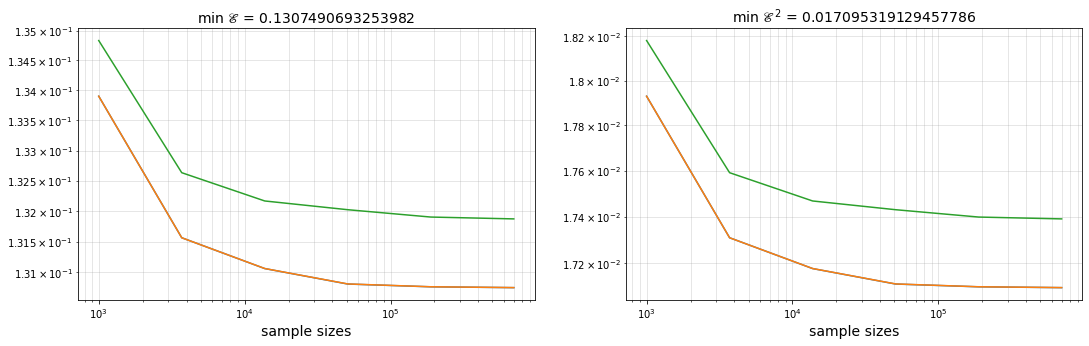

In [165]:
def show_model_limit_mse(model, test_X, test_Y, start_power=1):
    
    print(model)
    print(model.info())
    
    var_f = np.var(test_Y)
    print('var f', var_f)
    
    num = 6 #10
    #start_power = np.log10(model._basis_functions_number + 30)
    end_power = np.log10(len(test_Y) * 0.7)
    train_sizes = np.logspace(start_power, end_power, num=num, endpoint=True, base=10.0, dtype=np.int)

    
    test_size = len(test_Y) - np.max(train_sizes)
    
    print('train sizes:', train_sizes, ' + test size:', test_size)
    
    lambdas = np.array([0, 10**-4, 10**-2])# np.array([0, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1])
    
    
    errs = []
    for train_size in train_sizes:
        
        err = []
        
        tr_X = test_X[:train_size]
        tr_Y = test_Y[:train_size]
        te_X = test_X[-test_size:]
        te_Y = test_Y[-test_size:]
            
        for ls_lambda in lambdas:
    
            model.fit(tr_X, tr_Y, method='ls', ls_lambda=ls_lambda)
            err += [ model.validate(te_X, te_Y)['mse']]
            
        #model.fit(tr_X, tr_Y, method='projection')
        #err += [ model.validate(te_X, te_Y)['mse']]
        
        err = np.array(err)
        
        errs += [err]
        
    errs = np.array(errs)
    
    plt.figure(figsize=(18,5))
    plt.subplot(1,2,1)
    plt.loglog(train_sizes, np.sqrt(errs / var_f))
    plt.grid(b=True, which='both', color='#999999', axis='x',linestyle='-', alpha=0.3)
    plt.grid(b=True, which='both', color='#999999', axis='y',linestyle='-', alpha=0.3)
    plt.xlabel('sample sizes', fontsize=14)
    plt.title("min $\mathscr{E}$ = %s"%np.min(np.sqrt(errs / var_f)), fontsize=14)

    plt.subplot(1,2,2)
    plt.loglog(train_sizes, errs / var_f)
    plt.grid(b=True, which='both', color='#999999', axis='x',linestyle='-', alpha=0.3)
    plt.grid(b=True, which='both', color='#999999', axis='y',linestyle='-', alpha=0.3)
    plt.xlabel('sample sizes', fontsize=14)
    plt.title("min $\mathscr{E}^2$ = %s"%np.min(errs / var_f), fontsize=14)


    return errs

errs = show_model_limit_mse(model, test_X, test_Y, start_power=3)

In [162]:
errs / var_f

array([[0.0179299 , 0.01792975, 0.0181801 ],
       [0.0173091 , 0.01730896, 0.01759168],
       [0.01717671, 0.01717688, 0.01746826],
       [0.01711067, 0.01711106, 0.01743029],
       [0.01709887, 0.01709908, 0.01739846],
       [0.01709532, 0.01709549, 0.01739048]])

In [164]:
var_f,  np.std(test_Y)

(0.5306361108375467, 0.7284477406358995)

In [159]:
np.min(errs / var_f)

0.017095319129457786

In [166]:
np.sqrt(np.min(errs / var_f))

0.1307490693253982

In [163]:
np.sqrt(errs  / var_f)

array([[0.13390258, 0.13390203, 0.13483359],
       [0.13156404, 0.13156352, 0.13263363],
       [0.13105997, 0.1310606 , 0.13216753],
       [0.13080776, 0.13080924, 0.13202381],
       [0.13076263, 0.13076344, 0.13190322],
       [0.13074907, 0.13074972, 0.13187298]])